## Feature Extraction using Catch22

In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113658 sha256=316a67449aa7ec2a5ab294a514776445f178fb19a1846880e22cd4879722cb53
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [ ]:
import numpy as np
import pickle
import pandas as pd
from pycatch22 import catch22_all

In [ ]:
file_path = "/content/drive/MyDrive/Thesis/compiled_pupil_6D_array.pkl"
with open(file_path, "rb") as f:
    pupil_data = pickle.load(f)  # shape: (subjects, conditions, epochs, time, channels, eyes)

# Access the NumPy array within the dictionary using the 'data' key
data = pupil_data['data']
print(data.shape)

(64, 9, 55, 3481, 1, 2)


In [ ]:
# Create a mapping from condition names to event codes
conditions =  pupil_data["conditions"]

# Example event code mapping (Adapt to your specific event codes and conditions):
condition_to_event_code = {
    'justlisten/five': 500105,
    'memory/correct/five': 6001051,
    'memory/incorrect/five': 6001050,
    'justlisten/nine': 500109,
    'memory/correct/nine': 6001091,
    'memory/incorrect/nine': 6001090,
    'justlisten/thirteen': 500113,
    'memory/correct/thirteen': 6001131,
    'memory/incorrect/thirteen': 6001130,
}

# Function to retrieve event code based on condition index
def get_event_code(condition_index):
    condition_name = conditions[condition_index]
    return condition_to_event_code.get(condition_name)

# === Event code to label mapping ===
event_code_map = {
    500105: (0, 0),  # justlisten/five
    6001051: (1, 1),  # memory/correct/five
    6001050: (1, 1),  # memory/incorrect/five
    500109: (0, 0),
    6001091: (1, 2),
    6001090: (1, 2),
    500113: (0, 0),
    6001131: (1, 3),
    6001130: (1, 3),
}

In [ ]:
# === Feature Extraction ===
features_list = []
binary_labels = []
multiclass_labels = []

print("⚙️ Extracting features using catch22...")

for subj_idx, subj in enumerate(data):
    for cond_idx, condition in enumerate(subj):
        condition_name = conditions[cond_idx]
        event_code = condition_to_event_code.get(condition_name)

        if event_code not in event_code_map:
            continue

        for ep_idx, epoch in enumerate(condition):
            feature_vector = []
            for ch in range(epoch.shape[1]):
                for eye in range(epoch.shape[2]):
                    signal = epoch[:, ch, eye]
                    signal = signal[~np.isnan(signal)]
                    if len(signal) < 10:
                        features = [np.nan] * 22
                    else:
                        features = catch22_all(signal)["values"]
                    feature_vector.extend(features)

            features_list.append(feature_vector)
            binary_labels.append(event_code_map[event_code][0])
            multiclass_labels.append(event_code_map[event_code][1])

X = np.array(features_list)
y_binary = np.array(binary_labels)
y_multi = np.array(multiclass_labels)

print("✅ Feature extraction complete.")
print("X shape:", X.shape)
print("Binary label distribution:", np.bincount(y_binary))
print("Multiclass label distribution:", np.bincount(y_multi))


⚙️ Extracting features using catch22...
✅ Feature extraction complete.
X shape: (31680, 44)
Binary label distribution: [10560 21120]
Multiclass label distribution: [10560  7040  7040  7040]


In [ ]:
print("Unique values in y_multiclass:", np.unique(y_multi))
print("Unique values in y_binary:", np.unique(y_binary))

Unique values in y_multiclass: [0 1 2 3]
Unique values in y_binary: [0 1]


In [ ]:
# Assuming X, y_binary, and y_multi are your processed NumPy arrays

save_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"

data_to_save = {
    'features': X,
    'binary_labels': y_binary,
    'multiclass_labels': y_multi
}

with open(save_path, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"💾 Processed data saved to: {save_path}")

## CNN

In [ ]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import time

In [ ]:
# === Load extracted features ===
load_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"

with open(load_path, 'rb') as f:
  loaded_data = pickle.load(f)

X_loaded = loaded_data['features']
y_binary_loaded = loaded_data['binary_labels']
y_multi_loaded = loaded_data['multiclass_labels']

print(f" Loaded features: {X_loaded.shape}, Labels: {len(y_binary_loaded)}, Labels: {len(y_multi_loaded)} ")

 Loaded features: (31680, 44), Labels: 31680, Labels: 31680 


In [ ]:
# ===  Binary ===
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# === Prepare Data (with SMOTE) ===
n_samples, n_features = X_loaded.shape
image_shape = (11, 4)  # adjust as per X.shape[1]
assert np.prod(image_shape) == n_features, "Reshape dimensions must match feature size"

X_reshaped = X_loaded.reshape((n_samples, *image_shape, 1))
X_reshaped_2d = X_reshaped.reshape(n_samples, -1)

# Impute NaN values using SimpleImputer before applying SMOTE
imputer = SimpleImputer(strategy='mean')  # or other strategies like 'median', 'most_frequent'
X_reshaped_2d = imputer.fit_transform(X_reshaped_2d)

# Perform the train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_reshaped_2d, y_binary_loaded, test_size=0.2, random_state=42, stratify=y_binary_loaded)


# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled training class distribution:", Counter(y_train_resampled))

# Reshape back to the original image shape if necessary for your model
X_train_resampled = X_train_resampled.reshape(-1, *image_shape, 1)
X_test = X_test.reshape(-1, *image_shape, 1) # Reshape X_test as well

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).permute(0, 3, 1, 2)  # Change shape to (samples, channels, height, width)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Resampled training class distribution: Counter({np.int64(0): 16896, np.int64(1): 16896})


In [ ]:

class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()

        # Increase initial filters and add better architecture with deeper layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)

        # Lower dropout rate to prevent underfitting while maintaining regularization
        self.dropout = nn.Dropout(0.25)

        # Adjust based on flattened shape
        self.fc1 = nn.Linear(256 * 2 * 1, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 256 * 2 * 1)
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
model = CNNModel()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:

# === Train Model ===
epochs = 30
train_losses = []
train_accuracies = []
val_accuracies = []


# Use early stopping to prevent overfitting
best_val_acc = 0
patience = 5
counter = 0

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

start_time = time.time()  # Start time for training

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    # Update learning rate based on validation accuracy
    scheduler.step(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        counter = 0

        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()  # End time for training
training_time = end_time - start_time
print(f"\n⏱️ Training Time: {training_time:.2f} seconds")

# Load the best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/30, Loss: 0.7144, Train Accuracy: 0.4974, Val Accuracy: 0.4923
Epoch 2/30, Loss: 0.7024, Train Accuracy: 0.5067, Val Accuracy: 0.4771
Epoch 3/30, Loss: 0.7014, Train Accuracy: 0.4965, Val Accuracy: 0.5571
Epoch 4/30, Loss: 0.6981, Train Accuracy: 0.5027, Val Accuracy: 0.4776
Epoch 5/30, Loss: 0.6971, Train Accuracy: 0.4983, Val Accuracy: 0.4987
Epoch 6/30, Loss: 0.6960, Train Accuracy: 0.5014, Val Accuracy: 0.4689
Epoch 7/30, Loss: 0.6952, Train Accuracy: 0.5016, Val Accuracy: 0.4410
Epoch 8/30, Loss: 0.6949, Train Accuracy: 0.5027, Val Accuracy: 0.5835
Epoch 9/30, Loss: 0.6945, Train Accuracy: 0.5003, Val Accuracy: 0.4399
Epoch 10/30, Loss: 0.6943, Train Accuracy: 0.5019, Val Accuracy: 0.4176
Epoch 11/30, Loss: 0.6947, Train Accuracy: 0.5002, Val Accuracy: 0.4599
Epoch 12/30, Loss: 0.6937, Train Accuracy: 0.5070, Val Accuracy: 0.4132
Epoch 13/30, Loss: 0.6939, Train Accuracy: 0.5036, Val Accuracy: 0.4485
Early stopping at epoch 13

⏱️ Training Time: 409.21 seconds


<All keys matched successfully>

⏱️ Evaluation Time: 1.1923 seconds
📋 CNN Classification Report:

              precision    recall  f1-score   support

           0       0.32      0.23      0.27      2112
           1       0.66      0.76      0.71      4224

    accuracy                           0.58      6336
   macro avg       0.49      0.49      0.49      6336
weighted avg       0.55      0.58      0.56      6336

🎯 Accuracy (CNN): 0.5834911616161617


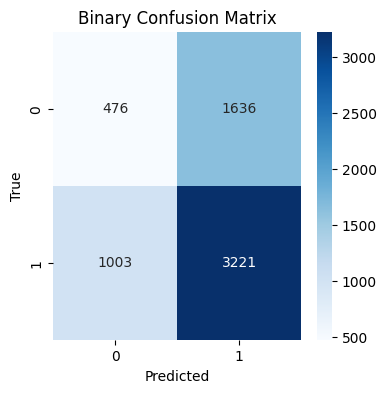

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# === Evaluate ===
model.eval()
y_pred = []
y_true = []

start_time_eval = time.time() # Start time for evaluation

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

end_time_eval = time.time() # End time for evaluation
evaluation_time = end_time_eval - start_time_eval
print(f"⏱️ Evaluation Time: {evaluation_time:.4f} seconds")


print("📋 CNN Classification Report:\n")
print(classification_report(y_true, y_pred))
print("🎯 Accuracy (CNN):", accuracy_score(y_true, y_pred))

# Confusion matrix (binary)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# === Feature Importance using SHAP ===
import shap

# We need a version of the model that outputs probabilities for SHAP
class CNNModelForSHAP(nn.Module):
    def __init__(self, original_model):
        super(CNNModelForSHAP, self).__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            original_model.conv2,
            original_model.bn2,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            original_model.conv3,
            original_model.bn3,
            nn.ReLU(),
            original_model.dropout
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            original_model.fc1,
            original_model.bn4,
            nn.ReLU(),
            original_model.dropout,
            original_model.fc2,
            original_model.bn5,
            nn.ReLU(),
            original_model.dropout,
            original_model.fc3,
            nn.Softmax(dim=1) # Output probabilities
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# Create a SHAP explainer
shap_model = CNNModelForSHAP(model)
shap_model.eval()

# Select a subset of the test data for SHAP analysis to reduce computation
background = X_test_tensor[np.random.choice(X_test_tensor.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(shap_model, background)

# Explain a few samples from the test set
shap_values = explainer.shap_values(X_test_tensor[:10]) # Explain the first 10 test samples

# Flatten SHAP values for one sample and class
sample_shap_values = shap_values[0][0].flatten()

# Top 10 important features
top_10_feature_indices = np.argsort(np.abs(sample_shap_values))[-10:]

# Ensure feature names match total number of features (reshaped image size)
original_feature_names = [f'feature_{i+1}' for i in range(sample_shap_values.shape[0])]

top_10_original_features = [original_feature_names[i] for i in top_10_feature_indices]

print("\n🔍 Top 10 Features (SHAP Importance):")
for i, feature_name in enumerate(top_10_original_features):
    print(f"{i+1}. {feature_name}")



/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f"unrecognized nn.Module: {module_type}")



🔍 Top 10 Features (SHAP Importance):
1. feature_63
2. feature_8
3. feature_50
4. feature_19
5. feature_5
6. feature_64
7. feature_15
8. feature_16
9. feature_20
10. feature_60


In [ ]:
#=======MultiClass======
# === Prepare Data (with SMOTE) ===

n_samples, n_features = X_loaded.shape
image_shape = (11, 4)  # adjust as per X.shape[1]
assert np.prod(image_shape) == n_features, "Reshape dimensions must match feature size"

X_reshaped = X_loaded.reshape((n_samples, *image_shape, 1))
X_reshaped_2d = X_reshaped.reshape(n_samples, -1)


# Impute NaN values using SimpleImputer before applying SMOTE
imputer = SimpleImputer(strategy='mean')  # or other strategies like 'median', 'most_frequent'
X_reshaped_2d = imputer.fit_transform(X_reshaped_2d)


# Perform the train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_reshaped_2d, y_multi_loaded, test_size=0.2, random_state=42, stratify=y_multi_loaded)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Resampled training class distribution:", Counter(y_train_resampled))

# Reshape back to the original image shape if necessary for your model
X_train_resampled = X_train_resampled.reshape(-1, *image_shape, 1)
X_test = X_test.reshape(-1, *image_shape, 1) # Reshape X_test as well

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).permute(0, 3, 1, 2)  # Change shape to (samples, channels, height, width)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Resampled training class distribution: Counter({np.int64(2): 8448, np.int64(3): 8448, np.int64(1): 8448, np.int64(0): 8448})


In [ ]:
# === Define CNN Model ===

class CNNClassifier(nn.Module):

    def __init__(self, num_classes=4):
        super(CNNClassifier, self).__init__()

        # Increased filters and added batch normalization for better learning
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        # Reduced dropout to prevent underfitting
        self.dropout = nn.Dropout(0.3)

        # Adjusted based on the input image shape
        self.fc1 = nn.Linear(128 * 2 * 1, 128)
        self.fc2 = nn.Linear(128, num_classes)



    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128 * 2 * 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Use class weights to handle imbalance
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device here
model = CNNClassifier(num_classes=4).to(device)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# Use Adam optimizer with lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)



In [ ]:
epochs = 30
train_losses = []
val_accuracies = []

start_time_train = time.time() # Start time for training

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)


    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    # Update learning rate based on validation accuracy
    scheduler.step(val_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

end_time_train = time.time() # End time for training
training_time = end_time_train - start_time_train
print(f"\n⏱️ Training Time: {training_time:.2f} seconds")


Epoch 1/30, Loss: 1.3021, Train Acc: 0.3625, Val Acc: 0.3723
Epoch 2/30, Loss: 1.2483, Train Acc: 0.4062, Val Acc: 0.3826
Epoch 3/30, Loss: 1.2226, Train Acc: 0.4216, Val Acc: 0.3794
Epoch 4/30, Loss: 1.2122, Train Acc: 0.4318, Val Acc: 0.4003
Epoch 5/30, Loss: 1.2038, Train Acc: 0.4338, Val Acc: 0.4029
Epoch 6/30, Loss: 1.1963, Train Acc: 0.4378, Val Acc: 0.3995
Epoch 7/30, Loss: 1.1908, Train Acc: 0.4406, Val Acc: 0.4048
Epoch 8/30, Loss: 1.1888, Train Acc: 0.4435, Val Acc: 0.4135
Epoch 9/30, Loss: 1.1839, Train Acc: 0.4461, Val Acc: 0.4072
Epoch 10/30, Loss: 1.1812, Train Acc: 0.4475, Val Acc: 0.4062
Epoch 11/30, Loss: 1.1785, Train Acc: 0.4511, Val Acc: 0.4083
Epoch 12/30, Loss: 1.1751, Train Acc: 0.4513, Val Acc: 0.4066
Epoch 13/30, Loss: 1.1695, Train Acc: 0.4563, Val Acc: 0.4094
Epoch 14/30, Loss: 1.1694, Train Acc: 0.4520, Val Acc: 0.4108
Epoch 15/30, Loss: 1.1654, Train Acc: 0.4576, Val Acc: 0.4108
Epoch 16/30, Loss: 1.1651, Train Acc: 0.4550, Val Acc: 0.4141
Epoch 17/30, Loss

⏱️ Evaluation Time: 0.9365 seconds

📊 Multi-class Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2112
           1       0.44      0.79      0.56      1408
           2       0.41      0.40      0.40      1408
           3       0.39      0.68      0.50      1408

    accuracy                           0.41      6336
   macro avg       0.31      0.47      0.37      6336
weighted avg       0.28      0.41      0.33      6336

🎯 Accuracy: 0.41429924242424243


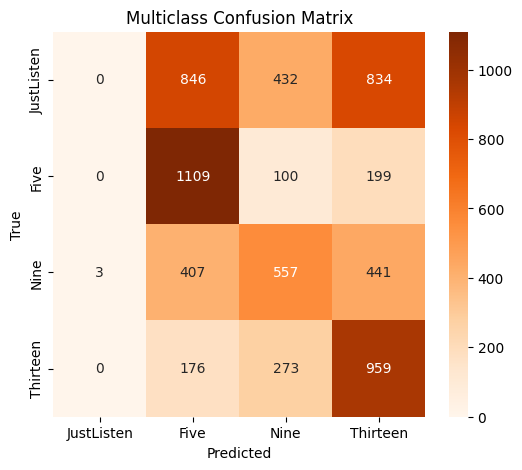

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# === Evaluate ===

model.eval()
all_preds = []
all_true = []

start_time_eval = time.time() # Start time for evaluation

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(labels.numpy())

end_time_eval = time.time() # End time for evaluation
evaluation_time = end_time_eval - start_time_eval
print(f"⏱️ Evaluation Time: {evaluation_time:.4f} seconds")

# Report
print("\n📊 Multi-class Classification Report:")
print(classification_report(all_true, all_preds))
print("🎯 Accuracy:", accuracy_score(all_true, all_preds))

# Confusion matrix (multiclass)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(all_true, all_preds), annot=True, fmt='d', cmap='Oranges',
            xticklabels=["JustListen", "Five", "Nine", "Thirteen"],
            yticklabels=["JustListen", "Five", "Nine", "Thirteen"])
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# === Feature Importance using SHAP ===
import shap

# We need a version of the model that outputs probabilities for SHAP
class CNNClassifierForSHAP(nn.Module):
    def __init__(self, original_model, num_classes):
        super(CNNClassifierForSHAP, self).__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            original_model.conv2,
            original_model.bn2,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            original_model.dropout
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            original_model.fc1,
            nn.ReLU(),
            original_model.fc2,
            nn.Softmax(dim=1) # Output probabilities
        )
        self.num_classes = num_classes

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# Create a SHAP explainer
shap_model = CNNClassifierForSHAP(model.cpu(), num_classes=4) # Move model to CPU for SHAP
shap_model.eval()

# Select a subset of the test data for SHAP analysis to reduce computation
background = X_test_tensor[:100].cpu()
explainer = shap.DeepExplainer(shap_model, background)

# Explain a few samples from the test set
shap_values = explainer.shap_values(X_test_tensor[:10].cpu()) # Explain the first 10 test samples

# Flatten mean SHAP values to ensure 1D array
mean_shap_values_flat = mean_shap_values.flatten()

# Get indices of top 10 features
top_10_feature_indices = np.argsort(mean_shap_values_flat)[::-1][:10]

# Map indices to feature names
original_feature_names = [f'feature_{i+1}' for i in range(mean_shap_values_flat.shape[0])]
top_10_original_features = [original_feature_names[int(i)] for i in top_10_feature_indices]

# Display
print("\n🔍 Top 10 Features (SHAP Importance):")
for i, feature_name in enumerate(top_10_original_features):
    print(f"{i+1}. {feature_name}")



🔍 Top 10 Features (SHAP Importance):
1. feature_126
2. feature_127
3. feature_40
4. feature_39
5. feature_38
6. feature_102
7. feature_15
8. feature_128
9. feature_104
10. feature_118


## XGBoost

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from xgboost import XGBClassifier

In [ ]:
# Load features
load_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"
with open(load_path, 'rb') as f:
    loaded_data = pickle.load(f)

X = loaded_data['features']
y = loaded_data['binary_labels']

In [ ]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
start_time_train = time.time() # Start time for training

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=1,  # Optional: can be tuned if imbalance persists
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_resampled, y_train_resampled)

end_time_train = time.time() # End time for training
training_time = end_time_train - start_time_train
print(f"\n⏱️ Training Time: {training_time:.2f} seconds")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:49:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



⏱️ Training Time: 1.45 seconds


⏱️ Prediction Time: 0.0199 seconds
📋 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.11      0.16      2112
           1       0.66      0.87      0.75      4224

    accuracy                           0.61      6336
   macro avg       0.47      0.49      0.45      6336
weighted avg       0.54      0.61      0.55      6336

🎯 Accuracy (XGBoost): 0.6133207070707071


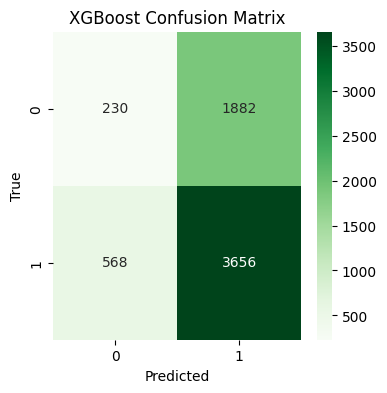

In [ ]:
start_time_predict = time.time() # Start time for prediction

y_pred = model.predict(X_test)

end_time_predict = time.time() # End time for prediction
prediction_time = end_time_predict - start_time_predict
print(f"⏱️ Prediction Time: {prediction_time:.4f} seconds")

print("📋 XGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("🎯 Accuracy (XGBoost):", accuracy_score(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



🔍 Top 10 Features (SHAP Importance):
1. feature_39: 0.2165
2. feature_17: 0.1782
3. feature_20: 0.1081
4. feature_42: 0.0837
5. feature_19: 0.0424
6. feature_41: 0.0387
7. feature_9: 0.0250
8. feature_14: 0.0235
9. feature_31: 0.0231
10. feature_15: 0.0213


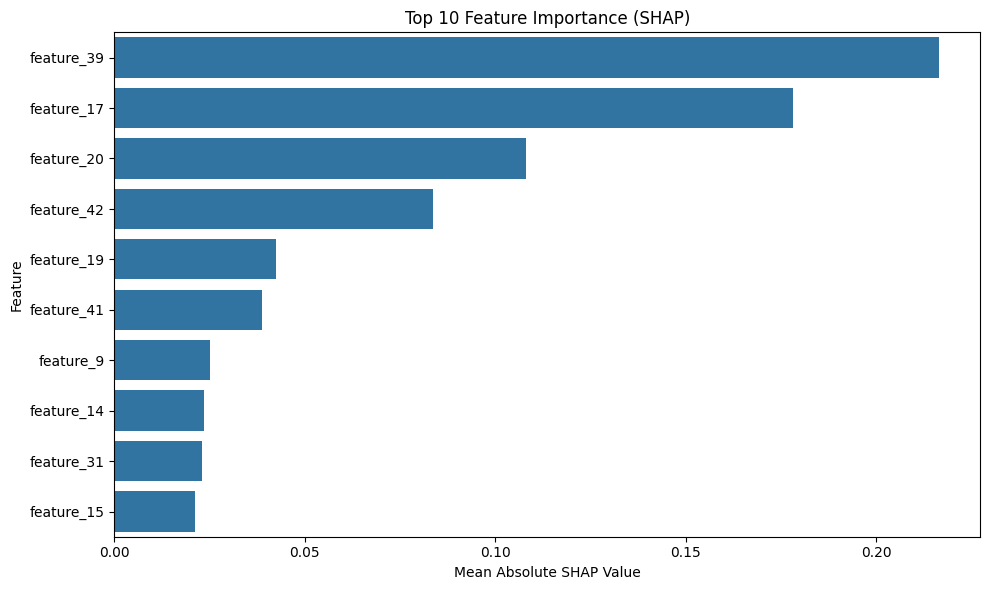

In [ ]:
# === Feature Importance using SHAP ===
import shap

# Create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Get feature importance based on SHAP values
feature_importance = np.abs(shap_values).mean(axis=0)

# Get the indices of the top 10 most important features
top_10_feature_indices = np.argsort(feature_importance)[::-1][:10]

# Assuming your original features have names (if not, we'll use indices)
original_feature_names = [f'feature_{i+1}' for i in range(X.shape[1])] # Generate default names

# Get the names of the top 10 features
top_10_features = [original_feature_names[i] for i in top_10_feature_indices]
top_10_importances = feature_importance[top_10_feature_indices]

print("\n🔍 Top 10 Features (SHAP Importance):")
for i, (feature, importance) in enumerate(zip(top_10_features, top_10_importances)):
    print(f"{i+1}. {feature}: {importance:.4f}")

# Optional: Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_importances, y=top_10_features)
plt.title("Top 10 Feature Importance (SHAP)")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:50:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



⏱️ Training Time: 5.38 seconds
⏱️ Prediction Time: 0.0608 seconds

📊 XGBoost Classification Report:
              precision    recall  f1-score   support

 Just Listen       0.25      0.17      0.20      2112
    Memory-5       0.62      0.92      0.74      1408
    Memory-9       0.56      0.53      0.55      1408
   Memory-13       0.62      0.65      0.64      1408

    accuracy                           0.52      6336
   macro avg       0.51      0.57      0.53      6336
weighted avg       0.48      0.52      0.50      6336

 Accuracy (XGBoost): 0.5235164141414141


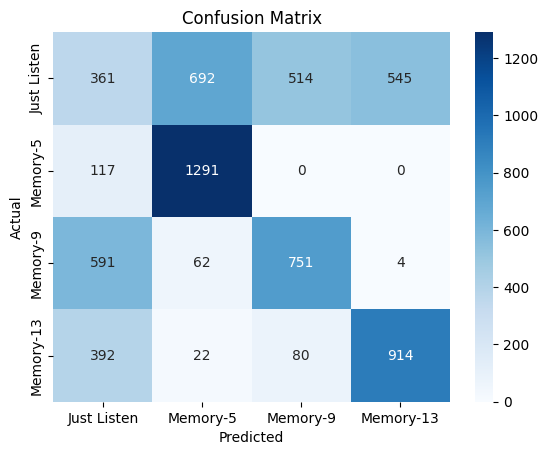


🔍 Top 10 Features (SHAP Importance):
1. feature_2: 0.0634
2. feature_4: 0.0590
3. feature_3: 0.0288
4. feature_1: 0.0087


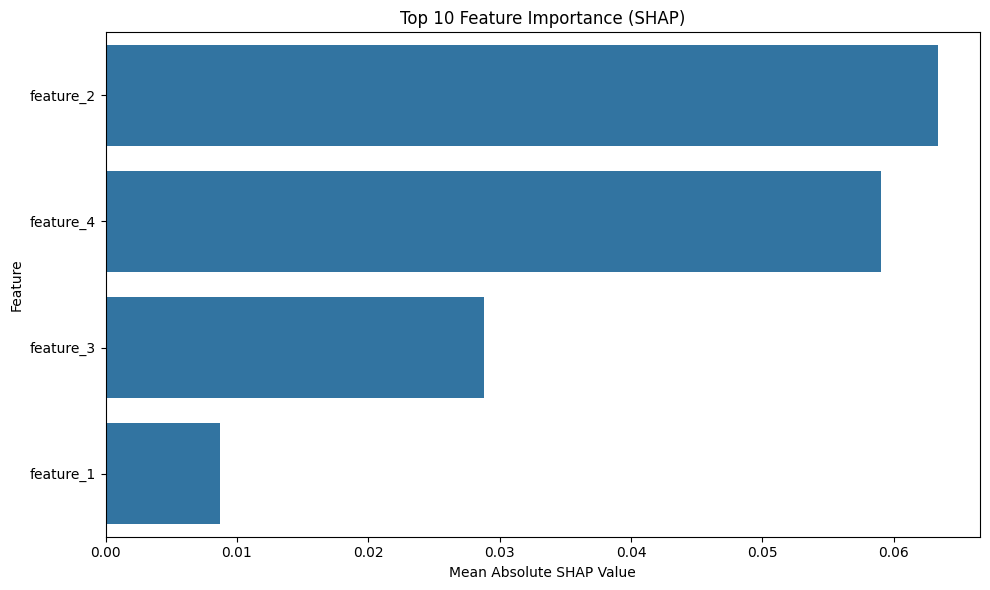

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import time

# ------------------ Load Data ------------------ #
def load_features(path):
    with open("/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl", 'rb') as f:
        data = pickle.load(f)
    return data['features'], data['multiclass_labels']

# ------------------ Plot Confusion Matrix ------------------ #
def plot_conf_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# ------------------ Train XGBoost ------------------ #
def run_xgboost_multiclass(pickle_path):
    features, labels = load_features(pickle_path)

    # Flatten (N, T, F) or (N, F, T) to (N, T*F)
    if features.ndim == 3:
        features = features.reshape(features.shape[0], -1)

    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    X_train, X_val, y_train, y_val = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )

    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        eval_metric='mlogloss',
        use_label_encoder=False,
        max_depth=5,
        n_estimators=100,
        learning_rate=0.1
    )

    start_time_train = time.time()
    model.fit(X_train, y_train)
    end_time_train = time.time()
    training_time = end_time_train - start_time_train
    print(f"\n⏱️ Training Time: {training_time:.2f} seconds")

    start_time_predict = time.time()
    preds = model.predict(X_val)
    end_time_predict = time.time()

    prediction_time = end_time_predict - start_time_predict
    print(f"⏱️ Prediction Time: {prediction_time:.4f} seconds")

    label_names = ["Just Listen", "Memory-5", "Memory-9", "Memory-13"]
    print("\n📊 XGBoost Classification Report:")
    print(classification_report(y_val, preds, target_names=label_names))
    print(" Accuracy (XGBoost):", accuracy_score(y_val, preds))
    plot_conf_matrix(y_val, preds, labels=label_names)

    # --- SHAP Feature Importance ---
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)

    # For multiclass, shap_values is a list of arrays, one for each class
    # We can take the average absolute SHAP value across all classes
    mean_shap_values = np.mean(np.abs(np.concatenate(shap_values, axis=0)), axis=0)

    # Get the indices of the top 10 features
    top_10_feature_indices = np.argsort(mean_shap_values)[::-1][:10]

    # Assuming your original features have names (if not, we'll use indices)
    num_original_features = 44  # Update this if your flattened feature size changes
    original_feature_names = [f'feature_{i+1}' for i in range(num_original_features)]

    top_10_features = [original_feature_names[i] for i in top_10_feature_indices]
    top_10_importances = mean_shap_values[top_10_feature_indices]

    print("\n🔍 Top 10 Features (SHAP Importance):")
    for i, (feature, importance) in enumerate(zip(top_10_features, top_10_importances)):
        print(f"{i+1}. {feature}: {importance:.4f}")

    # Optional: Visualize feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10_importances, y=top_10_features)
    plt.title("Top 10 Feature Importance (SHAP)")
    plt.xlabel("Mean Absolute SHAP Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


# ------------------ Run ------------------ #
if __name__ == "__main__":
    run_xgboost_multiclass("extracted_features.pkl")


## RandomForest

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from imblearn.combine import SMOTEENN
import time
import shap

In [ ]:
# === Load extracted features ===

load_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"

with open(load_path, 'rb') as f:
    loaded_data = pickle.load(f)

X_loaded = loaded_data['features']
y_binary_loaded = loaded_data['binary_labels']
y_multi_loaded = loaded_data['multiclass_labels']

print(f"Loaded features shape: {X_loaded.shape}")
print(f"Binary label distribution: {np.bincount(y_binary_loaded)}")
print(f"Multiclass label distribution: {np.bincount(y_multi_loaded)}")

Loaded features shape: (31680, 44)
Binary label distribution: [10560 21120]
Multiclass label distribution: [10560  7040  7040  7040]


In [ ]:
# Advanced preprocessing pipeline for better performance

# 1. Handle missing values with robust strategy
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_loaded)


# 2. Apply power transformation to make features more Gaussian-like
power_transformer = PowerTransformer(method='yeo-johnson')
X_transformed = power_transformer.fit_transform(X_imputed)


# 3. Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)


# 4. Feature selection using a preliminary random forest
# This helps identify and keep only the most informative features
print("Performing feature selection...")
pre_selector = RandomForestClassifier(n_estimators=100, random_state=42)
pre_selector.fit(X_scaled, y_binary_loaded)
selector = SelectFromModel(pre_selector, threshold="mean", prefit=True)
X_selected = selector.transform(X_scaled)
print(f"Selected {X_selected.shape[1]} out of {X_scaled.shape[1]} features")

Performing feature selection...
Selected 26 out of 44 features


Applying SMOTEENN for balanced binary classification...
Class distribution after SMOTEENN:
Before: [ 8448 16896]
After: [1469  731]
Training Binary Classification Ensemble...
⏱️ Binary Training Time: 26.27 seconds
⏱️ Binary Prediction Time: 0.6477 seconds

🔍 Binary Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.84      0.45      2112
           1       0.46      0.07      0.12      4224

    accuracy                           0.33      6336
   macro avg       0.39      0.45      0.29      6336
weighted avg       0.41      0.33      0.23      6336

🎯 Accuracy (Binary): 0.3262


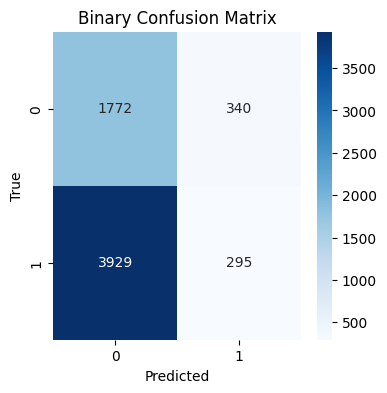

In [ ]:
# Binary Classification with ensemble approach

# Split data first
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_selected, y_binary_loaded, test_size=0.2, random_state=42, stratify=y_binary_loaded)

# Use SMOTEENN to handle imbalance - combines SMOTE and Edited Nearest Neighbors for better quality samples
print("Applying SMOTEENN for balanced binary classification...")
smoteenn = SMOTEENN(random_state=42)
X_train_bin_res, y_train_bin_res = smoteenn.fit_resample(X_train_bin, y_train_bin)

print("Class distribution after SMOTEENN:")
print(f"Before: {np.bincount(y_train_bin)}")
print(f"After: {np.bincount(y_train_bin_res)}")


# Create an ensemble of different models for better performance
# Base Random Forest
rf_bin = RandomForestClassifier(
    n_estimators=1000,             # More trees
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1,
    criterion='entropy',
    oob_score=True                 # Use out-of-bag estimate for internal validation
)


# Gradient Boosting Classifier for complex patterns
gb_bin = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)


# Voting ensemble combining both models
ensemble_bin = VotingClassifier(
    estimators=[
        ('rf', rf_bin),
        ('gb', gb_bin)
    ],
    voting='soft'  # Use predicted probabilities
)


print("Training Binary Classification Ensemble...")
start_time_bin_train = time.time()

# Train the ensemble model
ensemble_bin.fit(X_train_bin_res, y_train_bin_res)
end_time_bin_train = time.time()
train_time_bin = end_time_bin_train - start_time_bin_train
print(f"⏱️ Binary Training Time: {train_time_bin:.2f} seconds")

# Predict & Evaluate with improved ensemble
start_time_bin_predict = time.time()
y_pred_bin = ensemble_bin.predict(X_test_bin)

end_time_bin_predict = time.time()
predict_time_bin = end_time_bin_predict - start_time_bin_predict
print(f"⏱️ Binary Prediction Time: {predict_time_bin:.4f} seconds")


print("\n🔍 Binary Classification Report:\n")
print(classification_report(y_test_bin, y_pred_bin))
bin_accuracy = accuracy_score(y_test_bin, y_pred_bin)
print(f"🎯 Accuracy (Binary): {bin_accuracy:.4f}")


# Confusion matrix (binary)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test_bin, y_pred_bin), annot=True, fmt='d', cmap='Blues')
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Applying ADASYN for multiclass classification...
Multiclass distribution after ADASYN:
Before: [8448 5632 5632 5632]
After: [8448 8795 8400 8198]
Training Multiclass Ensemble...
⏱️ Multiclass Training Time: 726.81 seconds
⏱️ Multiclass Prediction Time: 2.2459 seconds

🔍 Multiclass Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2112
           1       0.60      0.71      0.65      1408
           2       0.54      0.51      0.52      1408
           3       0.46      0.67      0.55      1408

    accuracy                           0.42      6336
   macro avg       0.40      0.48      0.43      6336
weighted avg       0.36      0.42      0.38      6336

🎯 Accuracy (Multiclass): 0.4227
OOB Score (Random Forest component): 1.0000


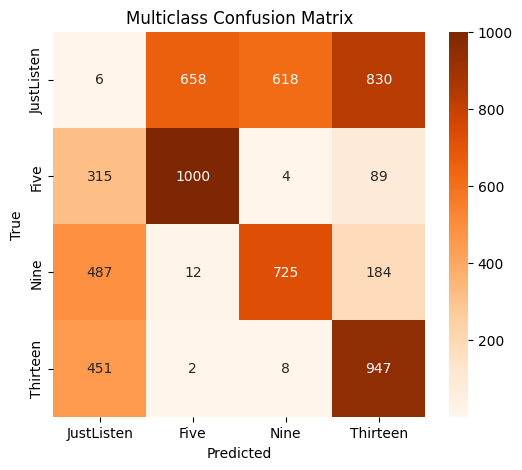

In [ ]:
# Multiclass Classification with improved approach
from imblearn.over_sampling import ADASYN

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_selected, y_multi_loaded, test_size=0.2, random_state=42, stratify=y_multi_loaded)


# Use ADASYN for multiclass (Adaptive Synthetic Sampling - better for multiclass)
print("Applying ADASYN for multiclass classification...")
adasyn = ADASYN(random_state=42)
X_train_multi_res, y_train_multi_res = adasyn.fit_resample(X_train_multi, y_train_multi)

print("Multiclass distribution after ADASYN:")
print(f"Before: {np.bincount(y_train_multi)}")
print(f"After: {np.bincount(y_train_multi_res)}")


# Create multiclass ensemble
rf_multi = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    criterion='entropy'
)

gb_multi = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)


ensemble_multi = VotingClassifier(
    estimators=[
        ('rf', rf_multi),
        ('gb', gb_multi)
    ],
    voting='soft'
)


print("Training Multiclass Ensemble...")
start_time_multi_train = time.time()
ensemble_multi.fit(X_train_multi_res, y_train_multi_res)

end_time_multi_train = time.time()
train_time_multi = end_time_multi_train - start_time_multi_train
print(f"⏱️ Multiclass Training Time: {train_time_multi:.2f} seconds")


# Predict & Evaluate with improved ensemble
start_time_multi_predict = time.time()
y_pred_multi = ensemble_multi.predict(X_test_multi)

end_time_multi_predict = time.time()
predict_time_multi = end_time_multi_predict - start_time_multi_predict
print(f"⏱️ Multiclass Prediction Time: {predict_time_multi:.4f} seconds")


print("\n🔍 Multiclass Classification Report:\n")
print(classification_report(y_test_multi, y_pred_multi))
multi_accuracy = accuracy_score(y_test_multi, y_pred_multi)
print(f"🎯 Accuracy (Multiclass): {multi_accuracy:.4f}")
print(f"OOB Score (Random Forest component): {rf_multi.oob_score:.4f}")


# Confusion matrix (multiclass)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_multi, y_pred_multi), annot=True, fmt='d', cmap='Oranges',
            xticklabels=["JustListen", "Five", "Nine", "Thirteen"],
            yticklabels=["JustListen", "Five", "Nine", "Thirteen"])
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


=== SHAP Feature Importance for Binary Classification (Random Forest) ===
Top 10 Features (Binary RF):
1. feature_1: 0.0097
2. feature_2: 0.0097


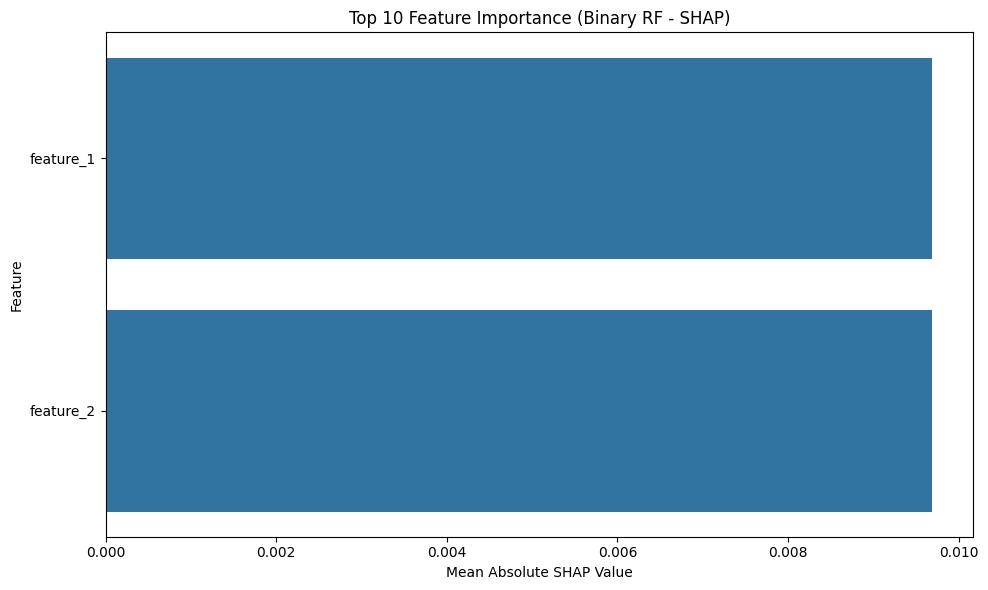

In [ ]:
# === SHAP Feature Importance ===

# Need to use a single estimator for SHAP, so we'll analyze the best performing one (Random Forest)

# Binary Classification SHAP
print("\n=== SHAP Feature Importance for Binary Classification (Random Forest) ===")
# Get the underlying RandomForest model from the VotingClassifier
explainer_bin_rf = shap.TreeExplainer(ensemble_bin.named_estimators_['rf']) # Updated line
shap_values_bin_rf = explainer_bin_rf.shap_values(X_test_bin)

# For binary, shap_values has two arrays (for each class). We can take the absolute mean over the positive class
shap_importance_bin_rf = np.abs(shap_values_bin_rf[1]).mean(axis=0)

# Assuming you have a variable num_selected_features representing the number of selected features
num_selected_features = X_selected.shape[1]  # Get the number of features from X_selected
feature_names = [f'feature_{i+1}' for i in range(num_selected_features)] # Use selected feature count

top_indices_bin = np.argsort(shap_importance_bin_rf)[::-1][:10]
top_features_bin = [feature_names[i] for i in top_indices_bin]
top_importances_bin = shap_importance_bin_rf[top_indices_bin]

print("Top 10 Features (Binary RF):")
for i, (feature, importance) in enumerate(zip(top_features_bin, top_importances_bin)):
    print(f"{i+1}. {feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances_bin, y=top_features_bin)
plt.title("Top 10 Feature Importance (Binary RF - SHAP)")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




In [ ]:
# Multiclass Classification SHAP
print("\n=== SHAP Feature Importance for Multiclass Classification (Random Forest) ===")
# Get the underlying RandomForest model from the VotingClassifier
explainer_multi_rf = shap.TreeExplainer(ensemble_multi.named_estimators_['rf']) # Updated line
shap_values_multi_rf = explainer_multi_rf.shap_values(X_test_multi)

# For multiclass, shap_values is a list of arrays. We can average the absolute values across all classes
shap_importance_multi_rf = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values_multi_rf], axis=0)

top_indices_multi = np.argsort(shap_importance_multi_rf)[::-1][:10]
top_features_multi = [feature_names[i] for i in top_indices_multi]
top_importances_multi = shap_importance_multi_rf[top_indices_multi]

print("Top 10 Features (Multiclass RF):")
for i, (feature, importance) in enumerate(zip(top_features_multi, top_importances_multi)):
    print(f"{i+1}. {feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances_multi, y=top_features_multi)
plt.title("Top 10 Feature Importance (Multiclass RF - SHAP)")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


=== SHAP Feature Importance for Multiclass Classification (Random Forest) ===


### LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# === Load extracted features ===
load_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"
import pickle
with open(load_path, 'rb') as f:
    loaded_data = pickle.load(f)

X_loaded = loaded_data['features']  # shape: (31680, 44)
y_binary_loaded = loaded_data['binary_labels'].astype(np.float32)
y_multi_loaded = loaded_data['multiclass_labels'].astype(np.float32)

print(f"Loaded features: {X_loaded.shape}, Binary Labels: {len(y_binary_loaded)}, Multiclass Labels: {len(y_multi_loaded)}")


Loaded features: (31680, 44), Binary Labels: 31680, Multiclass Labels: 31680


In [ ]:
# === Enhanced preprocessing pipeline ===
# 1. Handle missing values with robust strategy
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_loaded)

# 2. Apply power transformation to make features more Gaussian-like
power_transformer = PowerTransformer(method='yeo-johnson')
X_transformed = power_transformer.fit_transform(X_imputed)

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# 4. Feature selection for better model focus
print("Performing feature selection...")
pre_selector = RandomForestClassifier(n_estimators=100, random_state=42)
pre_selector.fit(X_scaled, y_binary_loaded)
selector = SelectFromModel(pre_selector, threshold="mean", prefit=True)
X_selected = selector.transform(X_scaled)
print(f"Selected {X_selected.shape[1]} out of {X_scaled.shape[1]} features")

# === Reshape for LSTM ===
feature_count = X_selected.shape[1]
if feature_count % 4 == 0:
    time_steps = feature_count // 4
    features = 4
else:
    for i in range(1, feature_count + 1):
        if feature_count % i == 0 and i <= feature_count // i:
            time_steps = i
            features = feature_count // i
            break

print(f"Reshaping to (samples, {time_steps}, {features}) for LSTM processing")
X = X_selected.reshape(X_selected.shape[0], time_steps, features).astype(np.float32)

# === Binary Classification ===
# === Split data first ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary_loaded, test_size=0.2, stratify=y_binary_loaded, random_state=42)

# === Handle Class Imbalance using SMOTE and RandomUnderSampler ===
print("Resampling training data...")
over = SMOTE(random_state=42, sampling_strategy=0.7)  # Oversample minority class to 70% of majority
under = RandomUnderSampler(random_state=42, sampling_strategy=0.8) # Undersample majority class to 80% of minority
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_resampled = X_train_resampled.reshape(-1, time_steps, features)

print("Class distribution after resampling:")
print(f"Before: {np.bincount(y_train.astype(int))}") # Convert y_train to int
print(f"After SMOTE + UnderSampling: {np.bincount(y_train_resampled.astype(int))}") # Convert y_train_resampled to int

# === Convert to tensors ===
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Performing feature selection...
Selected 26 out of 44 features
Reshaping to (samples, 1, 26) for LSTM processing
Resampling training data...
Class distribution after resampling:
Before: [ 8448 16896]
After SMOTE + UnderSampling: [11827 14783]


In [ ]:
# === Model ===
class AdvancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3):
        super().__init__()
        self.feature_projection = nn.Sequential(
            nn.Linear(input_size, input_size * 2),
            nn.LayerNorm(input_size * 2),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.lstm = nn.LSTM(
            input_size=input_size * 2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size * 2)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, 2)  # Binary classification
        )

    def forward(self, x):
        batch_size, seq_len, features = x.size()
        x = x.view(batch_size * seq_len, features)
        x = self.feature_projection(x)
        x = x.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        combined = self.layer_norm1(lstm_out + attn_out)
        max_pool = torch.max(combined, dim=1)[0]
        avg_pool = torch.mean(combined, dim=1)
        pooled = max_pool + avg_pool
        output = self.mlp(pooled)
        return output

# Create model with advanced architecture
model = AdvancedLSTM(input_size=features, hidden_size=256, num_layers=3).to(device)
print(model)

AdvancedLSTM(
  (feature_projection): Sequential(
    (0): Linear(in_features=26, out_features=52, bias=True)
    (1): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(52, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128, out_feat

In [ ]:
# Use AdamW optimizer with weight decay and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss() # Removed explicit class weights as we resampled
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# === Train with improved training loop ===
n_epochs = 40
best_f1 = 0
patience = 7
counter = 0
train_losses = []
val_f1_scores = []
start_time = time.time()  # Start time

print("\n=== Training Advanced LSTM for Binary Classification ===")
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluation phase
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    current_f1 = f1_score(y_true, y_pred)
    val_f1_scores.append(current_f1)

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}, F1-Score: {current_f1:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(model.state_dict(), 'best_lstm_binary_model_balanced.pth')
        if best_f1 > 0.85:  # Increased target F1 for early stopping
            print(f"Excellent F1-score achieved at epoch {epoch+1}. Stopping early.")
            break
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()  # End time
training_time = end_time - start_time
print(f"\n⏱️ Training Time: {training_time:.2f} seconds")



=== Training Advanced LSTM for Binary Classification ===
Epoch 1/40 - Loss: 0.6903, F1-Score: 0.8000, LR: 0.000452
Epoch 2/40 - Loss: 0.6878, F1-Score: 0.8000, LR: 0.000328
Epoch 3/40 - Loss: 0.6878, F1-Score: 0.8000, LR: 0.000173
Epoch 4/40 - Loss: 0.6872, F1-Score: 0.8000, LR: 0.000049
Epoch 5/40 - Loss: 0.6871, F1-Score: 0.8000, LR: 0.000500
Epoch 6/40 - Loss: 0.6878, F1-Score: 0.8000, LR: 0.000488
Epoch 7/40 - Loss: 0.6875, F1-Score: 0.8000, LR: 0.000452
Epoch 8/40 - Loss: 0.6874, F1-Score: 0.8000, LR: 0.000397
Early stopping at epoch 8

⏱️ Training Time: 902.48 seconds



⏱️ Prediction Time: 4.6120 seconds

🔍 Binary Classification Report (after balancing):

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2112
           1       0.67      1.00      0.80      4224

    accuracy                           0.67      6336
   macro avg       0.33      0.50      0.40      6336
weighted avg       0.44      0.67      0.53      6336

🎯 Final F1-Score: 0.8000
🎯 Final Accuracy: 0.6667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


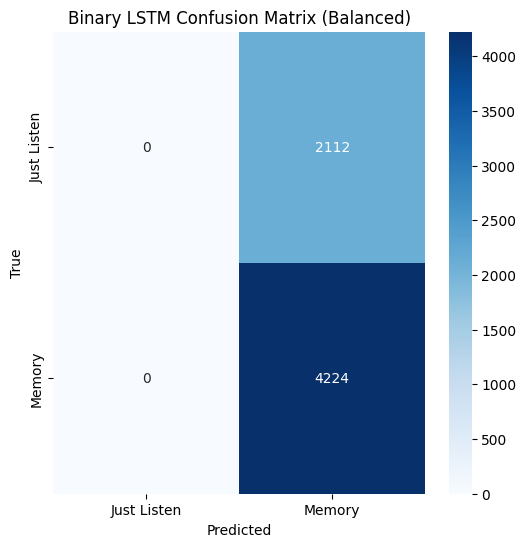

In [ ]:
# === Evaluate ===
model.load_state_dict(torch.load('best_lstm_binary_model_balanced.pth'))
model.eval()
y_true = []
y_pred = []
prediction_start_time = time.time()

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

prediction_end_time = time.time()  # End time for prediction
prediction_time = prediction_end_time - prediction_start_time
print(f"\n⏱️ Prediction Time: {prediction_time:.4f} seconds")

print("\n🔍 Binary Classification Report (after balancing):\n")
print(classification_report(y_true, y_pred))
print(f"🎯 Final F1-Score: {f1_score(y_true, y_pred):.4f}")
print(f"🎯 Final Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Just Listen", "Memory"],
            yticklabels=["Just Listen", "Memory"])
plt.title("Binary LSTM Confusion Matrix (Balanced)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


📊 Top 10 Feature Importances (from RandomForest feature selection):
feature_15: 0.0275
feature_14: 0.0273
feature_2: 0.0271
feature_23: 0.0268
feature_1: 0.0268
feature_36: 0.0268
feature_37: 0.0268
feature_6: 0.0266
feature_24: 0.0266
feature_28: 0.0266


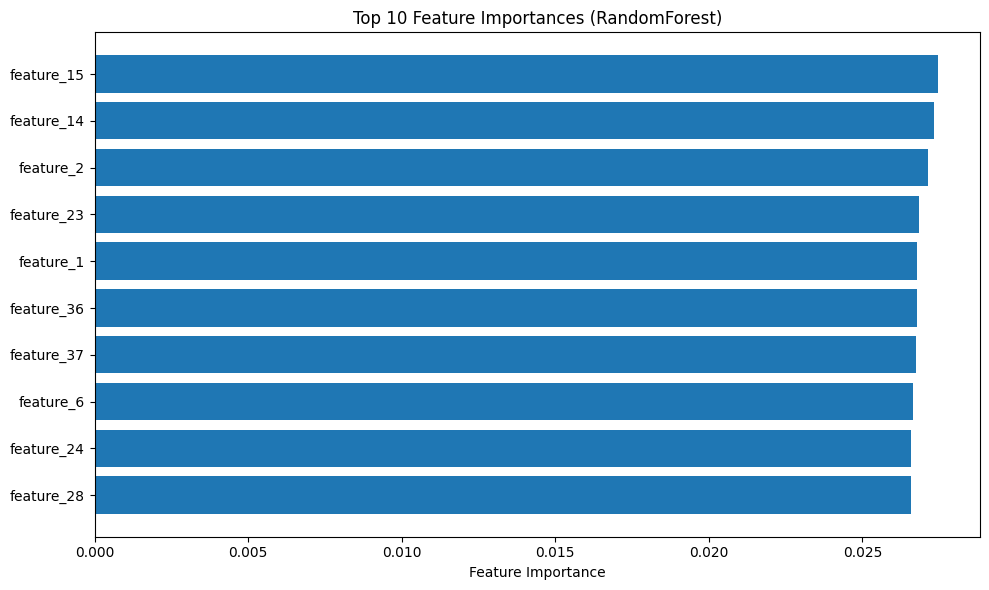

In [ ]:
# === SHAP Feature Importance ===
# ... (SHAP feature importance code remains the same as in the previous response)
import shap

# Get feature names (if available in your loaded data)
feature_names_catch22 = loaded_data.get('feature_names', [f'feature_{i+1}' for i in range(X_loaded.shape[1])])

# Get the indices of the selected features
selected_feature_indices = pre_selector.feature_importances_.argsort()[::-1]
support = selector.get_support()
selected_feature_names = [feature_names_catch22[i] for i, supported in enumerate(support) if supported]

# Get feature importances from the pre-selector (RandomForestClassifier)
importances = pre_selector.feature_importances_
selected_importances = importances[support]

# Sort feature importances and names
sorted_indices = np.argsort(selected_importances)[::-1]
top_10_indices = sorted_indices[:10]
top_10_importances = selected_importances[top_10_indices]
top_10_feature_names = [selected_feature_names[i] for i in top_10_indices]

print("\n📊 Top 10 Feature Importances (from RandomForest feature selection):")
for name, importance in zip(top_10_feature_names, top_10_importances):
    print(f"{name}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(top_10_feature_names[::-1], top_10_importances[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

In [ ]:
# ===== Multiclass Classification =====

from imblearn.over_sampling import ADASYN

# === Split data first ===
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi_loaded, test_size=0.2, random_state=42, stratify=y_multi_loaded)

# Apply ADASYN to balance classes (only on training data
X_train_multi_2d = X_train_multi.reshape(X_train_multi.shape[0], -1)
adasyn_multi = ADASYN(random_state=42)
X_train_multi_2d_resampled, y_train_multi_resampled = adasyn_multi.fit_resample(X_train_multi_2d, y_train_multi)
X_train_multi_resampled = X_train_multi_2d_resampled.reshape(-1, time_steps, features)

print("Multiclass distribution after ADASYN:")
print(f"Before: {np.bincount(y_train_multi.astype(int))}")
print(f"After: {np.bincount(y_train_multi_resampled.astype(int))}")

# === Convert to tensors ===
X_train_multi_tensor = torch.tensor(X_train_multi_resampled, dtype=torch.float32).to(device)
X_test_multi_tensor = torch.tensor(X_test_multi, dtype=torch.float32).to(device)
y_train_multi_tensor = torch.tensor(y_train_multi_resampled, dtype=torch.long).to(device)
y_test_multi_tensor = torch.tensor(y_test_multi, dtype=torch.long).to(device)


# Create DataLoader
train_multi_dataset = TensorDataset(X_train_multi_tensor, y_train_multi_tensor)
test_multi_dataset = TensorDataset(X_test_multi_tensor, y_test_multi_tensor)
train_multi_loader = DataLoader(train_multi_dataset, batch_size=batch_size, shuffle=True)
test_multi_loader = DataLoader(test_multi_dataset, batch_size=batch_size)

Multiclass distribution after ADASYN:
Before: [8448 5632 5632 5632]
After: [8448 8795 8400 8198]


In [ ]:
# === Advanced LSTM Model for Multiclass ===

class AdvancedLSTMMulticlass(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, num_classes=4):
        super().__init__()

        # Initial feature projection for better learning
        self.feature_projection = nn.Sequential(
            nn.Linear(input_size, input_size * 2),
            nn.LayerNorm(input_size * 2),
            nn.GELU(),
            nn.Dropout(0.2)
        )

        # Bidirectional LSTM with increased capacity
        self.lstm = nn.LSTM(
            input_size=input_size * 2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        # Multi-head self-attention for better feature extraction
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        # Skip connection and layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_size * 2)

        # Deep MLP classifier
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, num_classes)  # Multiclass
        )

    def forward(self, x):
        # Apply feature projection
        batch_size, seq_len, features = x.size()
        x = x.view(batch_size * seq_len, features)
        x = self.feature_projection(x)
        x = x.view(batch_size, seq_len, -1)

        # LSTM processing
        lstm_out, _ = self.lstm(x)  # shape: (batch, seq_len, hidden_size*2)

        # Self-attention mechanism
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # Residual connection and normalization
        combined = self.layer_norm1(lstm_out + attn_out)

        # Global max pooling & average pooling for sequence aggregation
        max_pool = torch.max(combined, dim=1)[0]
        avg_pool = torch.mean(combined, dim=1)
        pooled = max_pool + avg_pool  # Combine both signals

        # Classification head
        output = self.mlp(pooled)
        return output

In [ ]:
# Create multiclass model
num_classes = len(np.unique(y_multi_loaded))
model_multi = AdvancedLSTMMulticlass(input_size=features, hidden_size=256, num_layers=3, num_classes=num_classes).to(device)
print(model_multi)

# Use AdamW optimizer with weight decay
optimizer_multi = optim.AdamW(model_multi.parameters(), lr=0.0005, weight_decay=1e-4)

# Class weights for imbalanced multiclass problem
class_counts = np.bincount(y_train_multi_resampled.astype(int))
class_weights_multi = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights_multi = class_weights_multi / class_weights_multi.sum() * num_classes
class_weights_multi = class_weights_multi.to(device)
criterion_multi = nn.CrossEntropyLoss(weight=class_weights_multi)

# Learning rate scheduler with warm-up and cosine annealing
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler_multi = CosineAnnealingWarmRestarts(optimizer_multi, T_0=5, T_mult=2, eta_min=1e-6)

# === Train multiclass model ===
n_epochs_multi = 30
best_accuracy_multi = 0
patience_multi = 7
counter_multi = 0
start_time_multi = time.time()

print("\n=== Training Advanced LSTM for Multiclass Classification ===")

for epoch in range(n_epochs_multi):
    model_multi.train()
    total_loss_multi = 0

    for xb, yb in train_multi_loader:
        optimizer_multi.zero_grad()
        outputs = model_multi(xb)
        loss = criterion_multi(outputs, yb)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_multi.parameters(), max_norm=1.0)
        optimizer_multi.step()

    # Update learning rate
    scheduler_multi.step()
    current_lr = optimizer_multi.param_groups[0]['lr']

    avg_loss_multi = total_loss_multi / len(train_multi_loader.dataset)

    # Evaluation phase
    model_multi.eval()
    correct_multi = 0
    total_multi = 0

    with torch.no_grad():
        for xb, yb in test_multi_loader:
            outputs = model_multi(xb)
            _, predicted = torch.max(outputs, 1)
            total_multi += yb.size(0)
            correct_multi += (predicted == yb).sum().item()

    accuracy_multi = correct_multi / total_multi

    print(f"Epoch {epoch+1}/{n_epochs_multi} - Loss: {avg_loss_multi:.4f}, Accuracy: {accuracy_multi:.4f}, LR: {current_lr:.6f}")

    # Early stopping
    if accuracy_multi > best_accuracy_multi:
        best_accuracy_multi = accuracy_multi
        counter_multi = 0

        # Save the best model
        torch.save(model_multi.state_dict(), 'best_lstm_multiclass_model.pth')
        if accuracy_multi > 0.62:  # Stop early if we achieve excellent performance
            print(f"Excellent performance achieved at epoch {epoch+1}. Stopping early.")
            break

    else:
        counter_multi += 1
        if counter_multi >= patience_multi:
            print(f"Early stopping at epoch {epoch+1}")
            break
end_time_multi = time.time()
training_time_multi = end_time_multi - start_time_multi
print(f"\n⏱️ Multiclass Training Time: {training_time_multi:.2f} seconds")

# Load best model for final evaluation
model_multi.load_state_dict(torch.load('best_lstm_multiclass_model.pth'))

AdvancedLSTMMulticlass(
  (feature_projection): Sequential(
    (0): Linear(in_features=26, out_features=52, bias=True)
    (1): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(52, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128

<All keys matched successfully>


⏱️ Multiclass Prediction Time: 3.7853 seconds

📊 Multiclass Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2112
           1       0.51      0.83      0.63      1408
           2       0.41      0.54      0.47      1408
           3       0.45      0.71      0.55      1408

    accuracy                           0.46      6336
   macro avg       0.34      0.52      0.41      6336
weighted avg       0.31      0.46      0.37      6336

🎯 Final Multiclass Accuracy: 0.4618


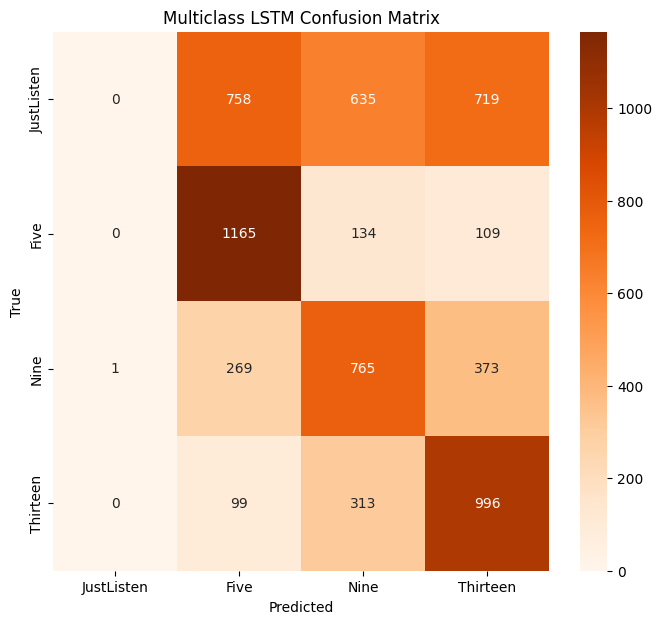

In [ ]:


# === Evaluate multiclass model ===
model_multi.eval()
y_true_multi = []
y_pred_multi = []
prediction_start_time_multi = time.time()

with torch.no_grad():
    for xb, yb in test_multi_loader:
        outputs = model_multi(xb)
        _, predicted = torch.max(outputs, 1)
        y_true_multi.extend(yb.cpu().numpy())
        y_pred_multi.extend(predicted.cpu().numpy())

prediction_end_time_multi = time.time()
prediction_time_multi = prediction_end_time_multi - prediction_start_time_multi
print(f"\n⏱️ Multiclass Prediction Time: {prediction_time_multi:.4f} seconds")

multi_accuracy = accuracy_score(y_true_multi, y_pred_multi)
print("\n📊 Multiclass Classification Report:")
print(classification_report(y_true_multi, y_pred_multi))
print(f"🎯 Final Multiclass Accuracy: {multi_accuracy:.4f}")



# Confusion matrix
plt.figure(figsize=(8, 7))
cm_multi = confusion_matrix(y_true_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["JustListen", "Five", "Nine", "Thirteen"],
            yticklabels=["JustListen", "Five", "Nine", "Thirteen"])
plt.title("Multiclass LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Transformer

 Features shape: (31680, 44)
 Binary labels shape: (31680,), Distribution: [10560 21120]
 Multiclass labels shape: (31680,), Distribution: [10560  7040  7040  7040]
Using device: cpu
Loaded X shape: (31680, 44)
Loaded Binary label distribution: [10560, 21120]
Loaded Multiclass label distribution: [10560, 7040, 7040, 7040]
Binary- class just listen-0 and memory engaged-1
Multi class- just listen-0, memory/five-1, memory/nine-2, memory/thirteen-3
Shape of X_train after SMOTE: (27034, 44)
Shape of y_train after SMOTE: (27034,), Distribution: [13517 13517]
--- Binary Transformer Training with SMOTE ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 0.6997, Val Loss: nan, Val Accuracy: 0.5212
Epoch 2/20, Train Loss: 0.6931, Val Loss: nan, Val Accuracy: 0.4704
Epoch 3/20, Train Loss: 0.6922, Val Loss: nan, Val Accuracy: 0.4774
Epoch 4/20, Train Loss: 0.6908, Val Loss: nan, Val Accuracy: 0.3967
Epoch 5/20, Train Loss: 0.6906, Val Loss: nan, Val Accuracy: 0.5053
Epoch 6/20, Train Loss: 0.6896, Val Loss: nan, Val Accuracy: 0.3828
Epoch 7/20, Train Loss: 0.6874, Val Loss: nan, Val Accuracy: 0.4427
Epoch 8/20, Train Loss: 0.6864, Val Loss: nan, Val Accuracy: 0.4283
Epoch 9/20, Train Loss: 0.6853, Val Loss: nan, Val Accuracy: 0.4353
Epoch 10/20, Train Loss: 0.6850, Val Loss: nan, Val Accuracy: 0.4118
Epoch 11/20, Train Loss: 0.6837, Val Loss: nan, Val Accuracy: 0.4546
Epoch 12/20, Train Loss: 0.6838, Val Loss: nan, Val Accuracy: 0.4400
Epoch 13/20, Train Loss: 0.6822, Val Loss: nan, Val Accuracy: 0.4330
Epoch 14/20, Train Loss: 0.6821, Val Loss: nan, Val Accuracy: 0.4383
Epoch 15/20, Train Loss: 0.6808, Val Loss: 

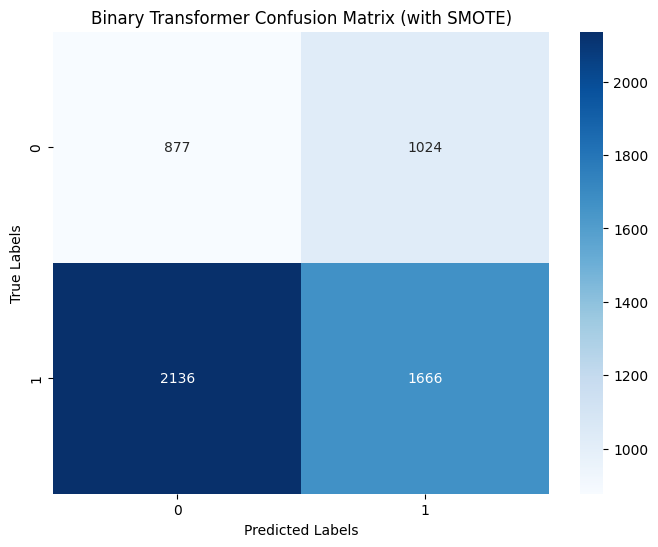

Test Accuracy: 0.4459
Test Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.46      0.36      1901
           1       0.62      0.44      0.51      3802

    accuracy                           0.45      5703
   macro avg       0.46      0.45      0.44      5703
weighted avg       0.51      0.45      0.46      5703

----------------------------------------
Shape of X_train after SMOTE: (27032, 44)
Shape of y_train after SMOTE: (27032,), Distribution: [6758 6758 6758 6758]
--- Cognitive Load Transformer Training with SMOTE ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 1.3564, Val Loss: nan, Val Accuracy: 0.3620
Epoch 2/20, Train Loss: 1.2598, Val Loss: nan, Val Accuracy: 0.3939
Epoch 3/20, Train Loss: 1.2231, Val Loss: nan, Val Accuracy: 0.4039
Epoch 4/20, Train Loss: 1.2048, Val Loss: nan, Val Accuracy: 0.4078
Epoch 5/20, Train Loss: 1.1863, Val Loss: nan, Val Accuracy: 0.4097
Epoch 6/20, Train Loss: 1.1739, Val Loss: nan, Val Accuracy: 0.4184
Epoch 7/20, Train Loss: 1.1662, Val Loss: nan, Val Accuracy: 0.4160
Epoch 8/20, Train Loss: 1.1596, Val Loss: nan, Val Accuracy: 0.4160
Epoch 9/20, Train Loss: 1.1545, Val Loss: nan, Val Accuracy: 0.4165
Epoch 10/20, Train Loss: 1.1520, Val Loss: nan, Val Accuracy: 0.4162
Epoch 11/20, Train Loss: 1.1456, Val Loss: nan, Val Accuracy: 0.4197
Epoch 12/20, Train Loss: 1.1419, Val Loss: nan, Val Accuracy: 0.4199
Epoch 13/20, Train Loss: 1.1369, Val Loss: nan, Val Accuracy: 0.4207
Epoch 14/20, Train Loss: 1.1381, Val Loss: nan, Val Accuracy: 0.4209
Epoch 15/20, Train Loss: 1.1348, Val Loss: 

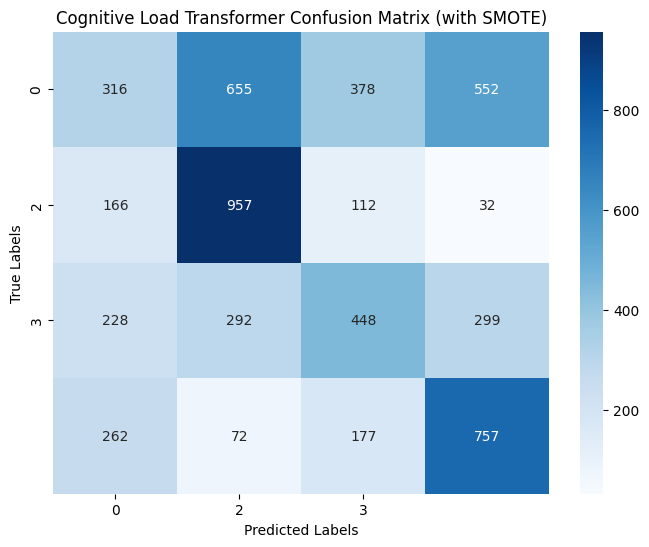

Test Accuracy: 0.4345
Test Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.17      0.22      1901
           1       0.48      0.76      0.59      1267
           2       0.40      0.35      0.38      1267
           3       0.46      0.60      0.52      1268

    accuracy                           0.43      5703
   macro avg       0.42      0.47      0.43      5703
weighted avg       0.41      0.43      0.40      5703

----------------------------------------


In [ ]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap

# ===== Load Data =====

def load_extracted_features(pickle_file_path):
    with open("/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl", 'rb') as f:
        data = pickle.load(f)
    return data['features'], data['binary_labels'], data['multiclass_labels']

# Load the data
features, y_binary, y_multiclass = load_extracted_features("/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl")

# Print shapes and distributions
print(f" Features shape: {features.shape}")
print(f" Binary labels shape: {y_binary.shape}, Distribution: {np.bincount(y_binary)}")
print(f" Multiclass labels shape: {y_multiclass.shape}, Distribution: {np.bincount(y_multiclass)}")

# Set the device to the first available CUDA GPU or CPU if no GPU is found
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, num_classes, dropout=0.1, d_model=64):
        super().__init__()
        self.embedding = nn.Linear(input_size, d_model)  # Project input to a higher dimension
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout),
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size) - here seq_len is 1
        embedded = self.dropout(torch.relu(self.embedding(x))) # (batch_size, 1, d_model)
        # Transformer expects (seq_len, batch_size, d_model)
        src = embedded.permute(1, 0, 2) # (1, batch_size, d_model)
        transformer_out = self.transformer_encoder(src) # (1, batch_size, d_model)
        # We can take the output of the first (and only) time step
        pooled_output = transformer_out[0] # (batch_size, d_model)
        output = self.fc(self.dropout(pooled_output)) # (batch_size, num_classes)
        return output

def train_and_evaluate_transformer_with_smote(data, labels, num_classes, classifier_name="Binary", params=None):
    if params is None:
        params = {
            'batch_size': 64,
            'learning_rate': 0.001,
            'num_heads': 4,
            'num_layers': 2,
            'dropout': 0.1,
            'epochs': 20,
            'validation_split': 0.2,
            'd_model': 64
        }

    # Split data BEFORE applying SMOTE
    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=1 - (1 - params['validation_split']) * 0.8, random_state=42, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean') # or 'median', 'most_frequent'
    X_train_scaled = imputer.fit_transform(X_train_scaled)

    # Apply SMOTE only to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Apply SMOTE only to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    print(f"Shape of X_train after SMOTE: {X_train_resampled.shape}")
    print(f"Shape of y_train after SMOTE: {y_train_resampled.shape}, Distribution: {np.bincount(y_train_resampled)}")

    # Reshape for Transformer: (batch_size, seq_len, features) where seq_len = 1
    X_train_tensor = torch.tensor(X_train_resampled.reshape(-1, 1, X_train_resampled.shape[1]), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val_scaled.reshape(-1, 1, X_val_scaled.shape[1]), dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1]), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

    input_size = X_train_resampled.shape[1] # Now the number of features after SMOTE (should be the same)
    model = TransformerClassifier(
        input_size=input_size,
        num_heads=params['num_heads'],
        num_layers=params['num_layers'],
        num_classes=num_classes,
        dropout=params['dropout'],
        d_model=params['d_model']
    ).to(device)

    # No need for class weights with SMOTE as the training data is balanced
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    print(f"--- {classifier_name} Transformer Training with SMOTE ---")
    start_time = time.time()
    for epoch in range(params['epochs']):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == targets).sum().item()
                total_samples += targets.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_predictions / total_samples
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{params['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    print(f"--- {classifier_name} Transformer Evaluation ---")
    model.eval()
    all_preds = []
    all_labels = []
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    evaluation_time = time.time() - start_time
    print(f"Evaluation Time: {evaluation_time:.4f} seconds")

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{classifier_name} Transformer Confusion Matrix (with SMOTE)')
    plt.show()

    print(f"Test Accuracy: {accuracy:.4f}")
    print("Test Classification Report:\n", report)
    print("-" * 40)

## Example Usage (replace 'extracted_features.pkl' with your file path)
pickle_file_path = 'pickle file/subcondition_catch22_features.pkl'
loaded_data = load_extracted_features(pickle_file_path)
reshaped_data, binary_labels, multiclass_labels = loaded_data

print(f"Loaded X shape: {reshaped_data.shape}")
print(f"Loaded Binary label distribution: {np.unique(binary_labels, return_counts=True)[1].tolist()}")
print(f"Loaded Multiclass label distribution: {np.unique(multiclass_labels, return_counts=True)[1].tolist()}")
print("Binary- class just listen-0 and memory engaged-1")
print("Multi class- just listen-0, memory/five-1, memory/nine-2, memory/thirteen-3")

# Step 1: Binary Classification (Just Listen vs. Memory) with SMOTE
binary_params = {
    'batch_size': 32,
    'learning_rate': 0.0001,
    'num_heads': 2,
    'num_layers': 1,
    'dropout': 0.05,
    'epochs': 20,
    'validation_split': 0.2,
    'd_model': 32
}
train_and_evaluate_transformer_with_smote(reshaped_data, binary_labels, 2, "Binary", binary_params)

# Step 2: Cognitive Load Classification (0, Low, Medium, High) with SMOTE
multiclass_params = {
    'batch_size': 32,
    'learning_rate': 0.00005,
    'num_heads': 2,
    'num_layers': 1,
    'dropout': 0.1,
    'epochs': 20,
    'validation_split': 0.2,
    'd_model': 32
}
train_and_evaluate_transformer_with_smote(reshaped_data, multiclass_labels, 4, "Cognitive Load", multiclass_params)

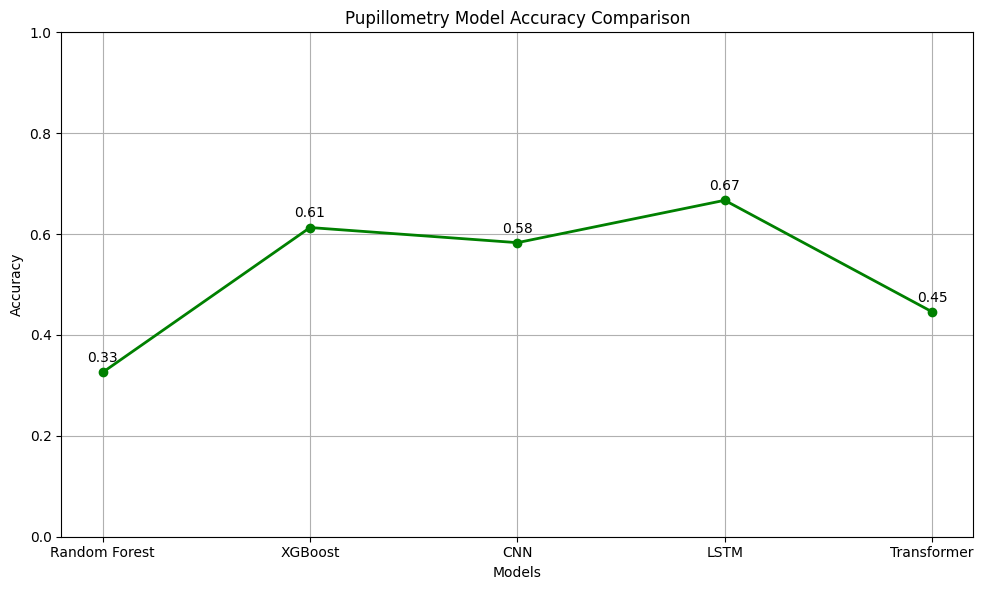

In [4]:
import matplotlib.pyplot as plt

# Model names
models = ['Random Forest', 'XGBoost', 'CNN', 'LSTM', 'Transformer']

# Corresponding accuracies (example values — replace with yours)
accuracies = [0.326, 0.613, 0.583, 0.667, 0.446]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', linestyle='-', color='green', linewidth=2)

plt.title('Pupillometry Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add data labels
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()
